In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 6.0 MB/s eta 0:00:00


In [2]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=de143e22c6cac692737c9c1333b732f96e676ae8193a7e9d10e497cf74044d58
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer


                       count       mean        std      min      25%  \
fixed acidity         1599.0   8.319637   1.741096  4.60000   7.1000   
volatile acidity      1599.0   0.527821   0.179060  0.12000   0.3900   
citric acid           1599.0   0.270976   0.194801  0.00000   0.0900   
residual sugar        1599.0   2.538806   1.409928  0.90000   1.9000   
chlorides             1599.0   0.087467   0.047065  0.01200   0.0700   
free sulfur dioxide   1599.0  15.874922  10.460157  1.00000   7.0000   
total sulfur dioxide  1599.0  46.467792  32.895324  6.00000  22.0000   
density               1599.0   0.996747   0.001887  0.99007   0.9956   
pH                    1599.0   3.311113   0.154386  2.74000   3.2100   
sulphates             1599.0   0.658149   0.169507  0.33000   0.5500   
alcohol               1599.0  10.422983   1.065668  8.40000   9.5000   
quality               1599.0   5.636023   0.807569  3.00000   5.0000   

                           50%        75%        max  
fixed ac

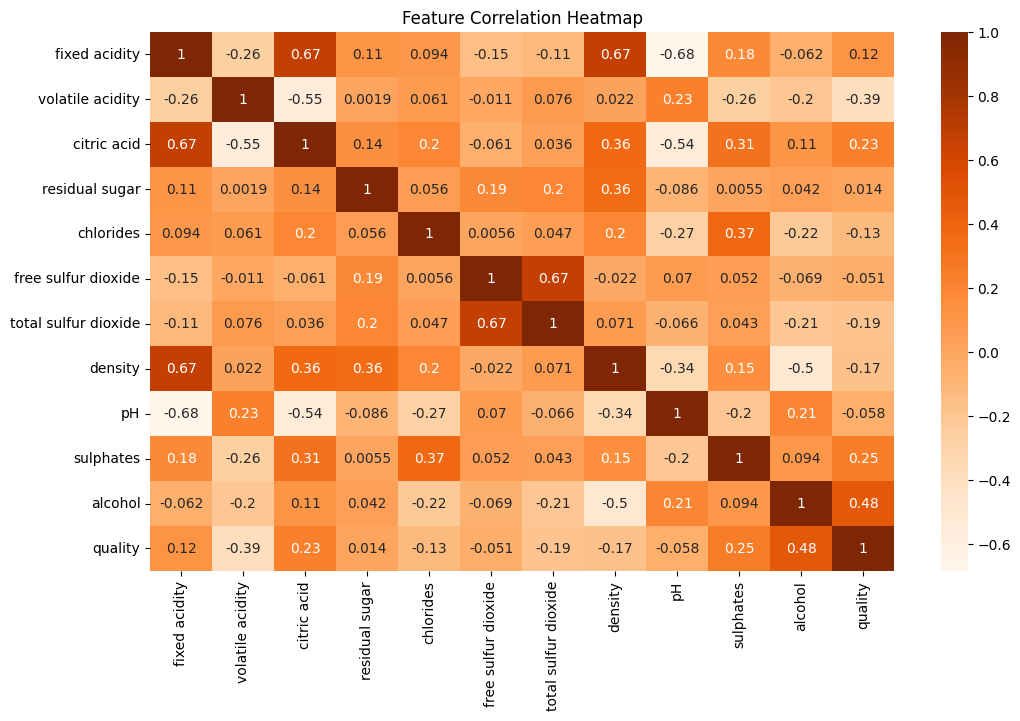

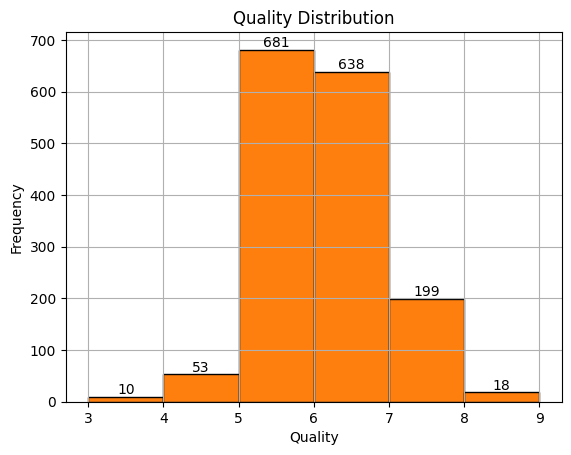

In [4]:
# Load and preprocess the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')  # Note the separator is ';'
X = data.drop("quality", axis=1)
y = data["quality"]

# Explore the dataset
print(data.describe().T)
print(data.corr())

plt.figure(figsize=(12, 7))
sns.heatmap(data.corr(), annot=True, cmap='Oranges')
plt.title("Feature Correlation Heatmap")
plt.show()

data["quality"].hist()

counts, bins, bars = plt.hist(data["quality"], bins=range(int(data["quality"].min()), int(data["quality"].max()) + 2), edgecolor="black")

# Annotate the frequency on each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(count)), ha="center", va="bottom", fontsize=10)

# Add titles and labels
plt.title("Quality Distribution")
plt.xlabel("Quality")
plt.ylabel("Frequency")
plt.title("Quality Distribution")
plt.xlabel("Quality")
plt.ylabel("Frequency")
plt.show()

# Binarize quality for a binary classification task
y = (y > 5).astype(int)

# Split data
random_state = 42  # You can choose any integer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


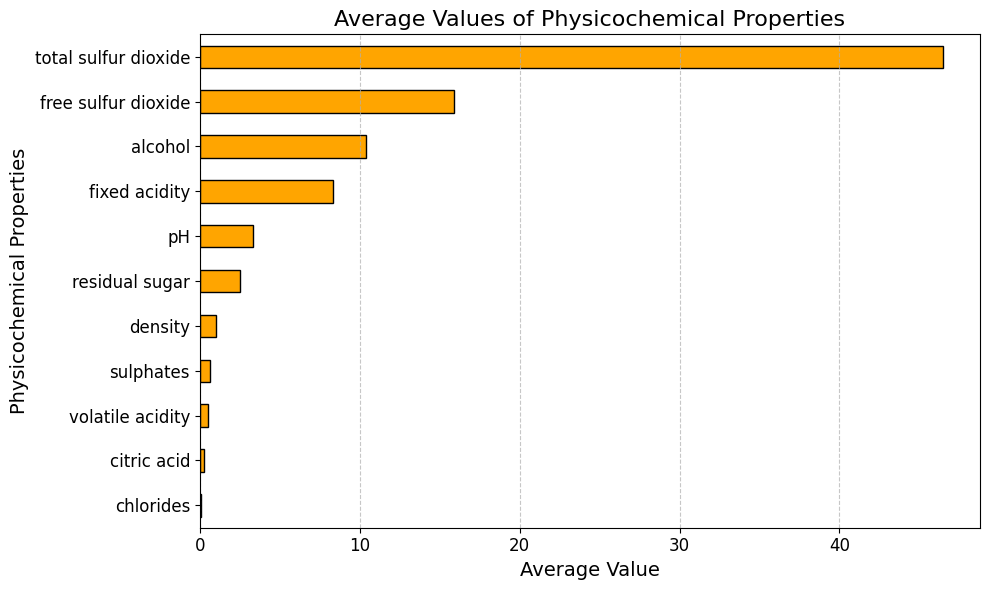

In [5]:
import matplotlib.pyplot as plt

# Ensure 'id' column is dropped if it exists
X = X.drop(columns=['id'], errors='ignore')

# Calculate the mean value of each physicochemical property
physicochemical_means = X.mean()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
physicochemical_means.sort_values(ascending=True).plot(kind='barh', color='orange', edgecolor='black')
plt.title("Average Values of Physicochemical Properties", fontsize=16)
plt.xlabel("Average Value", fontsize=14)
plt.ylabel("Physicochemical Properties", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [27]:
# Define models and hyperparameter grids
models = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10],
            "solver": ['lbfgs', 'liblinear']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 150, 200],
            "max_depth": [5, 10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    "SVC": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ['linear', 'rbf'],
            "gamma": [0.001, 0.01, 0.1, 1]
        }
    }
}

# Save the best-fitted models
best_models = {}

print("Grid Search Results:")
for model_name, config in models.items():
    grid_search = GridSearchCV(config["model"], config["params"], cv=5)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_  # Save the best-fitted model
    print(f"{model_name} - Best Params: {grid_search.best_params_}")
    print(f"{model_name} - Best CV Score: {grid_search.best_score_}")
    y_pred = grid_search.predict(X_test)
    print(f"{model_name} - Test Accuracy: {accuracy_score(y_test, y_pred)}\n")

# Bayesian Optimization with Optuna for Random Forest
print("Optuna Optimization Results:")
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)


# Print Optuna results
print(f"Optuna Best Params: {study.best_params}")
print(f"Optuna Best CV Score: {study.best_value}")

# Evaluate the best Random Forest from Optuna
optuna_rf = RandomForestClassifier(**study.best_params)
optuna_rf.fit(X_train, y_train)




Grid Search Results:
Logistic Regression - Best Params: {'C': 1, 'solver': 'lbfgs'}
Logistic Regression - Best CV Score: 0.7490202231520223
Logistic Regression - Test Accuracy: 0.7275

Random Forest - Best Params: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Best CV Score: 0.8165620641562065
Random Forest - Test Accuracy: 0.8



[I 2024-12-04 05:17:33,387] A new study created in memory with name: no-name-ac38dbe5-f917-4e20-8886-811bd8f11b62


SVC - Best Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC - Best CV Score: 0.7665062761506277
SVC - Test Accuracy: 0.76

Optuna Optimization Results:


[I 2024-12-04 05:17:33,665] Trial 0 finished with value: 0.8 and parameters: {'n_estimators': 76, 'max_depth': 24, 'min_samples_split': 5}. Best is trial 0 with value: 0.8.
[I 2024-12-04 05:17:34,156] Trial 1 finished with value: 0.81 and parameters: {'n_estimators': 115, 'max_depth': 30, 'min_samples_split': 10}. Best is trial 1 with value: 0.81.
[I 2024-12-04 05:17:34,920] Trial 2 finished with value: 0.7975 and parameters: {'n_estimators': 140, 'max_depth': 16, 'min_samples_split': 5}. Best is trial 1 with value: 0.81.
[I 2024-12-04 05:17:35,278] Trial 3 finished with value: 0.795 and parameters: {'n_estimators': 66, 'max_depth': 18, 'min_samples_split': 2}. Best is trial 1 with value: 0.81.
[I 2024-12-04 05:17:36,140] Trial 4 finished with value: 0.8 and parameters: {'n_estimators': 162, 'max_depth': 21, 'min_samples_split': 4}. Best is trial 1 with value: 0.81.
[I 2024-12-04 05:17:36,988] Trial 5 finished with value: 0.7875 and parameters: {'n_estimators': 162, 'max_depth': 9, 'mi

Optuna Best Params: {'n_estimators': 115, 'max_depth': 30, 'min_samples_split': 10}
Optuna Best CV Score: 0.81


RandomForestClassifier(max_depth=30, min_samples_split=10, n_estimators=115)

In [28]:
import pandas as pd

# Initialize a list to store the results
results = []

# Grid Search Results
for model_name, config in models.items():
    grid_search = GridSearchCV(config["model"], config["params"], cv=5)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_  # Save the best-fitted model
    grid_search_results = {
        "Model": model_name,
        "Best Params": str(grid_search.best_params_),
        "Best CV Score": grid_search.best_score_,
        "Test Accuracy": accuracy_score(y_test, grid_search.predict(X_test))
    }
    results.append(grid_search_results)

# Optuna Optimization Results for Random Forest
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

# Create the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Save Optuna results
optuna_results = {
    "Model": "Optuna Random Forest",
    "Best Params": str(study.best_params),
    "Best CV Score": study.best_value,
    "Test Accuracy": accuracy_score(y_test, optuna_rf.predict(X_test))
}
results.append(optuna_results)

# Create a DataFrame to tabulate the results
results_df = pd.DataFrame(results)

# Display the table
print(results_df)


[I 2024-12-04 05:20:32,417] A new study created in memory with name: no-name-9cc792d1-c952-45a6-9f5a-77a05e0b3a63
[I 2024-12-04 05:20:32,898] Trial 0 finished with value: 0.7875 and parameters: {'n_estimators': 139, 'max_depth': 27, 'min_samples_split': 7}. Best is trial 0 with value: 0.7875.
[I 2024-12-04 05:20:33,501] Trial 1 finished with value: 0.8125 and parameters: {'n_estimators': 170, 'max_depth': 50, 'min_samples_split': 2}. Best is trial 1 with value: 0.8125.
[I 2024-12-04 05:20:34,020] Trial 2 finished with value: 0.8 and parameters: {'n_estimators': 143, 'max_depth': 18, 'min_samples_split': 6}. Best is trial 1 with value: 0.8125.
[I 2024-12-04 05:20:34,511] Trial 3 finished with value: 0.79 and parameters: {'n_estimators': 143, 'max_depth': 43, 'min_samples_split': 7}. Best is trial 1 with value: 0.8125.
[I 2024-12-04 05:20:34,983] Trial 4 finished with value: 0.785 and parameters: {'n_estimators': 141, 'max_depth': 49, 'min_samples_split': 10}. Best is trial 1 with value:

                  Model                                        Best Params  \
0   Logistic Regression                        {'C': 1, 'solver': 'lbfgs'}   
1         Random Forest  {'max_depth': 30, 'min_samples_split': 2, 'n_e...   
2                   SVC           {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}   
3  Optuna Random Forest  {'n_estimators': 121, 'max_depth': 40, 'min_sa...   

   Best CV Score  Test Accuracy  
0       0.749020         0.7275  
1       0.814902         0.8025  
2       0.766506         0.7600  
3       0.815000         0.7950  



Logistic Regression Metrics:
Accuracy: 0.73
Precision: 0.77
Recall: 0.73
F1-Score: 0.75
Confusion Matrix:
[[130  48]
 [ 61 161]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       178
           1       0.77      0.73      0.75       222

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400


Random Forest Metrics:
Accuracy: 0.80
Precision: 0.81
Recall: 0.82
F1-Score: 0.82
Confusion Matrix:
[[136  42]
 [ 40 182]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       178
           1       0.81      0.82      0.82       222

    accuracy                           0.80       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.80      0.79       400


SVC Metrics:
Accuracy: 0.76
Precision: 0.79

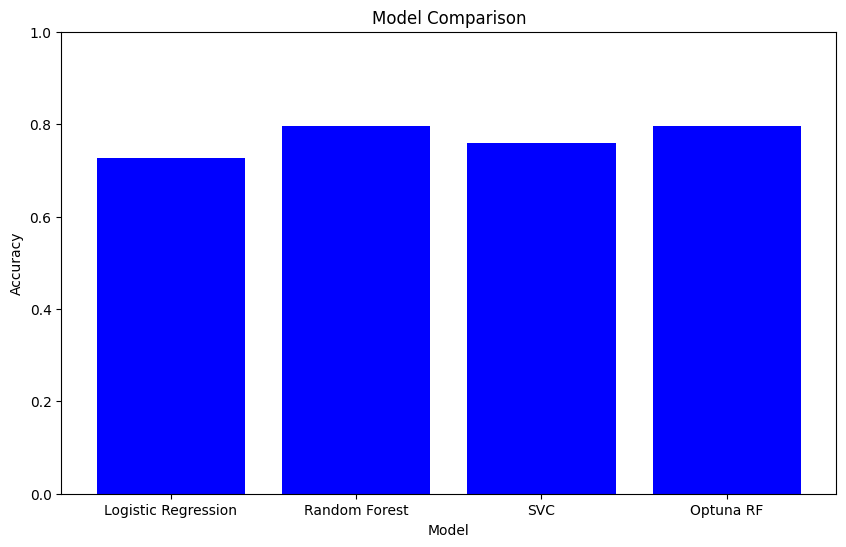

In [7]:
# Evaluate models
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Evaluate Logistic Regression
evaluate_model("Logistic Regression", best_models["Logistic Regression"], X_test, y_test)

# Evaluate Random Forest
evaluate_model("Random Forest", best_models["Random Forest"], X_test, y_test)

# Evaluate SVC
evaluate_model("SVC", best_models["SVC"], X_test, y_test)

# Evaluate Optuna Random Forest
evaluate_model("Optuna Random Forest", optuna_rf, X_test, y_test)

# Visualize metrics for all models
results = {
    "Logistic Regression": accuracy_score(y_test, best_models["Logistic Regression"].predict(X_test)),
    "Random Forest": accuracy_score(y_test, best_models["Random Forest"].predict(X_test)),
    "SVC": accuracy_score(y_test, best_models["SVC"].predict(X_test)),
    "Optuna RF": accuracy_score(y_test, optuna_rf.predict(X_test))
}

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()

In [8]:
from tabulate import tabulate

# Collect metrics for each model
model_metrics = [
    ["Logistic Regression",
     accuracy_score(y_test, best_models["Logistic Regression"].predict(X_test)),
     precision_score(y_test, best_models["Logistic Regression"].predict(X_test)),
     recall_score(y_test, best_models["Logistic Regression"].predict(X_test)),
     f1_score(y_test, best_models["Logistic Regression"].predict(X_test))],

    ["Random Forest",
     accuracy_score(y_test, best_models["Random Forest"].predict(X_test)),
     precision_score(y_test, best_models["Random Forest"].predict(X_test)),
     recall_score(y_test, best_models["Random Forest"].predict(X_test)),
     f1_score(y_test, best_models["Random Forest"].predict(X_test))],

    ["SVC",
     accuracy_score(y_test, best_models["SVC"].predict(X_test)),
     precision_score(y_test, best_models["SVC"].predict(X_test)),
     recall_score(y_test, best_models["SVC"].predict(X_test)),
     f1_score(y_test, best_models["SVC"].predict(X_test))],

    ["Optuna Random Forest",
     accuracy_score(y_test, optuna_rf.predict(X_test)),
     precision_score(y_test, optuna_rf.predict(X_test)),
     recall_score(y_test, optuna_rf.predict(X_test)),
     f1_score(y_test, optuna_rf.predict(X_test))]
]

# Define headers
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

# Tabulate results
print(tabulate(model_metrics, headers=headers, floatfmt=".2f"))


Model                   Accuracy    Precision    Recall    F1-Score
--------------------  ----------  -----------  --------  ----------
Logistic Regression         0.73         0.77      0.73        0.75
Random Forest               0.80         0.81      0.82        0.82
SVC                         0.76         0.79      0.77        0.78
Optuna Random Forest        0.80         0.81      0.83        0.82


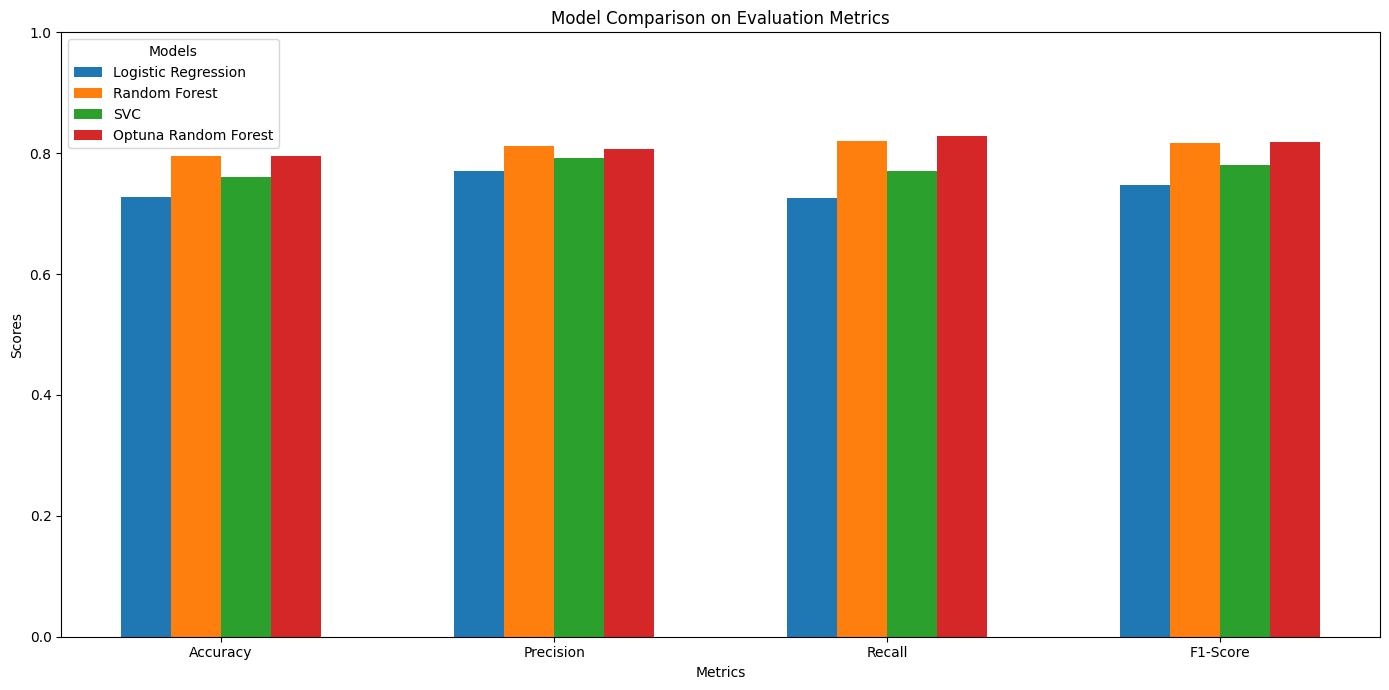

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for each model
metrics = {
    "Logistic Regression": [
        accuracy_score(y_test, best_models["Logistic Regression"].predict(X_test)),
        precision_score(y_test, best_models["Logistic Regression"].predict(X_test)),
        recall_score(y_test, best_models["Logistic Regression"].predict(X_test)),
        f1_score(y_test, best_models["Logistic Regression"].predict(X_test))
    ],
    "Random Forest": [
        accuracy_score(y_test, best_models["Random Forest"].predict(X_test)),
        precision_score(y_test, best_models["Random Forest"].predict(X_test)),
        recall_score(y_test, best_models["Random Forest"].predict(X_test)),
        f1_score(y_test, best_models["Random Forest"].predict(X_test))
    ],
    "SVC": [
        accuracy_score(y_test, best_models["SVC"].predict(X_test)),
        precision_score(y_test, best_models["SVC"].predict(X_test)),
        recall_score(y_test, best_models["SVC"].predict(X_test)),
        f1_score(y_test, best_models["SVC"].predict(X_test))
    ],
    "Optuna Random Forest": [
        accuracy_score(y_test, optuna_rf.predict(X_test)),
        precision_score(y_test, optuna_rf.predict(X_test)),
        recall_score(y_test, optuna_rf.predict(X_test)),
        f1_score(y_test, optuna_rf.predict(X_test))
    ]
}

# Metric names
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Plotting
bar_width = 0.15
x = np.arange(len(metric_names))
plt.figure(figsize=(14, 7))

# Plot each model's metrics
for i, (model_name, values) in enumerate(metrics.items()):
    plt.bar(x + i * bar_width, values, bar_width, label=model_name)

# Add labels, legend, and title
plt.xticks(x + bar_width * (len(metrics) - 1) / 2, metric_names)
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("Model Comparison on Evaluation Metrics")
plt.legend(title="Models", loc="upper left")
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()


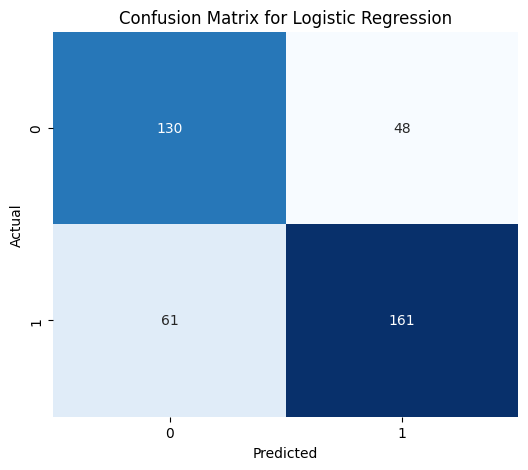

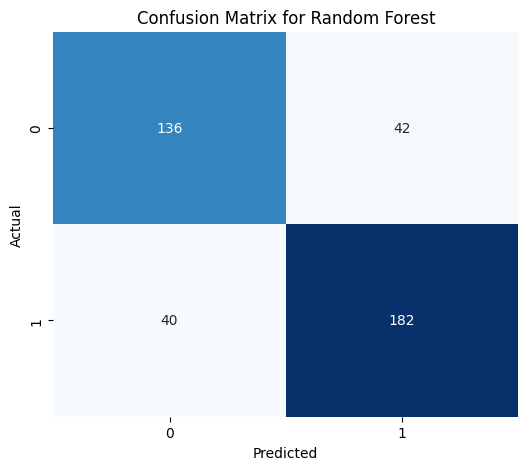

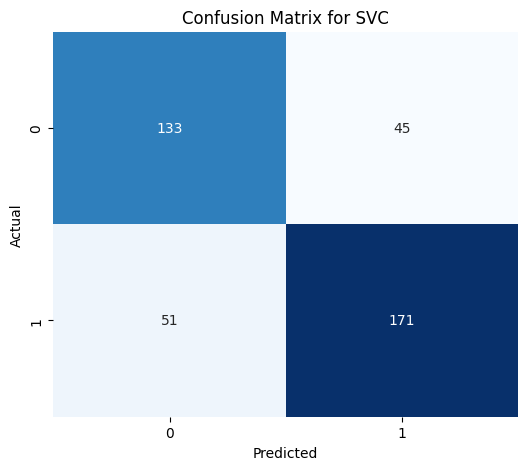

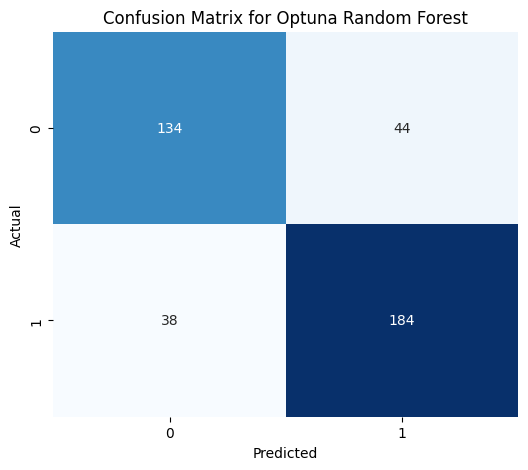

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot and save confusion matrix
def plot_confusion_matrix(model_name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{model_name}_confusion_matrix.png")  # Save as an image
    plt.show()

# Generate and save confusion matrices for all models
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(name, y_test, y_pred)

# Confusion matrix for Optuna Random Forest
y_pred_optuna_rf = optuna_rf.predict(X_test)
plot_confusion_matrix("Optuna Random Forest", y_test, y_pred_optuna_rf)
